In [208]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features, distribute_features_across_releases, apply_time_based_noise, apply_proportional_noise, remove_first_augmented_rows
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from config import GITHUB_TOKEN


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



In [209]:
# https://github.com/AMAI-GmbH/AI-Expert-Roadmap # no releases
# https://github.com/vim-airline/vim-airline # not enough release dates
# https://github.com/salesforce/LAVIS # not enough releases
# https://github.com/numenta/nupic-legacy  # last release in 2018

# Repos with lots of releases:
# https://github.com/crewAIInc/crewAI
# https://github.com/tensorflow/tensorflow
# https://github.com/magenta/magenta # 48 releases
test_df = get_single_repo_data('https://github.com/crewAIInc/crewAI', GITHUB_TOKEN)

test_df.head(20)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,0.65.2,2024-09-27T23:55:56Z,30,146,450,19612,2716,19612
1,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,0.64.0,2024-09-27T01:20:29Z,30,146,450,19612,2716,19612
2,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.63.6,2024-09-25T03:32:12Z,30,146,450,19612,2716,19612
3,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.63.5,2024-09-25T03:03:54Z,30,146,450,19612,2716,19612
4,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.63.2,2024-09-24T05:04:22Z,30,146,450,19612,2716,19612
5,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.63.1,2024-09-24T01:16:40Z,30,146,450,19612,2716,19612
6,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.63.0,2024-09-24T00:08:29Z,30,146,450,19612,2716,19612
7,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.61.0,2024-09-18T07:59:49Z,30,146,450,19612,2716,19612
8,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.60.0,2024-09-16T18:41:00Z,30,146,450,19612,2716,19612
9,crewAIInc,crewAI,"Framework for orchestrating role-playing, auto...",https://github.com/crewAIInc/crewAI,"agents, ai, ai-agents, llms",2023-10-27T03:26:59Z,2024-09-30T01:04:20Z,v0.55.2,2024-09-13T17:28:09Z,30,146,450,19612,2716,19612


In [210]:
if (test_df['num_releases'] <= 12).any():
    print('please provide a repos with more than 5 releases')


df_exploded = test_df 
df_exploded = df_exploded.sort_values(by='release_date', ascending=True).reset_index(drop=True)

df_augmented = distribute_features_across_releases(df_exploded, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues', 'num_releases'])
df_augmented = apply_time_based_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = apply_proportional_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = remove_first_augmented_rows(df_augmented)
df_augmented = add_growth_score_based_on_main_features(df_augmented, train=False)
actual_growth_score = df_augmented['growth_score']

test_df = df_augmented
test_df = add_repo_age_days_col(test_df)
test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

n_lag_features = 5
n_timesteps = 5

test_df = add_lag_features_based_on_target(test_df, num=n_lag_features)

print(actual_growth_score)
print("Last historical date:", test_df.index[-1])

/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['growth_score'] = scaled_features.sum(axis=1)
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['creation_date'] = pd.to_datetime(df['creation_date'])
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:255: SettingWithCopyWarn

0     0.042709
1     0.124781
2     0.196146
3     0.258265
4     0.336481
5     0.394888
6     0.459078
7     0.502246
8     0.542287
9     0.583639
10    0.603410
11    0.630597
12    0.659712
13    0.666615
14    0.728167
15    0.721708
16    0.745691
17    0.752027
18    0.767165
19    0.790868
20    0.821891
21    0.852648
22    0.896186
23    0.934730
24    0.994244
25    1.049452
26    1.106655
27    1.180614
28    1.261817
Name: growth_score, dtype: float64
Last historical date: 2024-09-27 23:55:56+00:00


/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_embedding'] = df['topics'].apply(lambda topic: sentence_embeddings_model.encode(topic))


In [211]:
print('test_df.shape', test_df.shape)
X = remove_unwanted_features(test_df)
print(X.shape)
X_scaled = scale_final_data(X=X.values)
X_scaled_pca = reduce_dimentionality_pca(X_scaled)

n_features_pca = X_scaled_pca.shape[1]

print(X_scaled_pca.shape[1], n_features_pca)
test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)

model = load_model('../models/best_rnn_model.keras')

print(X_scaled_pca.shape[0])
print(model.summary())

y_pred = model.predict(test_generator)
print(f'predicted: {y_pred}', f' | actual: {actual_growth_score}')

test_df.shape (24, 404)
(24, 397)
131 131
24


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 5, 131)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 5, 208)    │    212,784 │ input_layer_46[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 5, 208)    │          0 │ gru_46[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_46        │ (None, 5, 208)    │          0 │ dropout_91[0][0], │
│ (Attention)         │                   │            │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 5, 208)    │          0 │ dropout_91[0][0], │
│                     │                   │            │ attention_46[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 208)    │        416 │ add_45[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_45         │ (None, 208)       │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 64)        │     13,376 │ get_item_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 64)        │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 1)         │         65 │ dropout_92[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 679,925 (2.59 MB)

 Trainable params: 226,641 (885.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 453,284 (1.73 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
predicted: [[0.6644826 ]
 [0.63674605]
 [0.5811552 ]
 [0.5813046 ]
 [0.5803849 ]
 [0.578721  ]
 [0.5770011 ]
 [0.5818042 ]
 [0.5851233 ]
 [0.99508303]
 [0.847679  ]
 [0.83894956]
 [0.8334982 ]
 [0.8440198 ]
 [0.7076855 ]
 [0.6963736 ]
 [0.693182  ]
 [0.6875375 ]
 [0.696888  ]]  | actual: 0     0.042709
1     0.124781
2     0.196146
3     0.258265
4     0.336481
5     0.394888
6     0.459078
7     0.502246
8     0.542287
9     0.583639
10    0.603410
11    0.630597
12    0.659712
13    0.666615
14    0.728167
15    0.721708
16    0.745691
17    0.752027
18    0.767165
19    0.790868
20    0.821891
21    0.852648
22    0.896186
23    0.934730
24    0.994244
25    1.049452
26    1.106655
27    1.180614
28    1.261817
Name: growth_score, dtype: float64


In [212]:
# Use a few sample values from the actual data 
# just for sanity check to make sure the scaler is working correctly
sample_data = np.array([[0.3], [0.5], [0.7], [1.0], [1.2]])

scaler_y = joblib.load('../models/final_target_scaler.pkl')
scaled_data = scaler_y.transform(sample_data)
inverse_scaled_data = scaler_y.inverse_transform(scaled_data)

print("Original Data:\n", sample_data)
print("Scaled Data:\n", scaled_data)
print("Inverse Scaled Data:\n", inverse_scaled_data)

Original Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]
Scaled Data:
 [[0.28849993]
 [0.48083322]
 [0.67316651]
 [0.96166644]
 [1.15399973]]
Inverse Scaled Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]


In [213]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
print("Scaler data min:", scaler_y.data_min_)
print("Scaler data max:", scaler_y.data_max_)
print("Scaler feature range:", scaler_y.feature_range)


initial_data = X_scaled_pca[-n_timesteps:]
print(initial_data.shape)
print("Number of features in X_scaled_pca:", X_scaled_pca.shape[1])


# Perform the forecasting
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

Scaler data min: [0.]
Scaler data max: [1.03986159]
Scaler feature range: (0, 1)
(5, 131)
Number of features in X_scaled_pca: 131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecasted Growth Scores: [0.73143303 1.6294725  1.6170449  1.597182   1.5898643  1.7143999
 1.7135684  1.7135949  1.7135476  1.7134144  1.7132109  1.7132115 ]


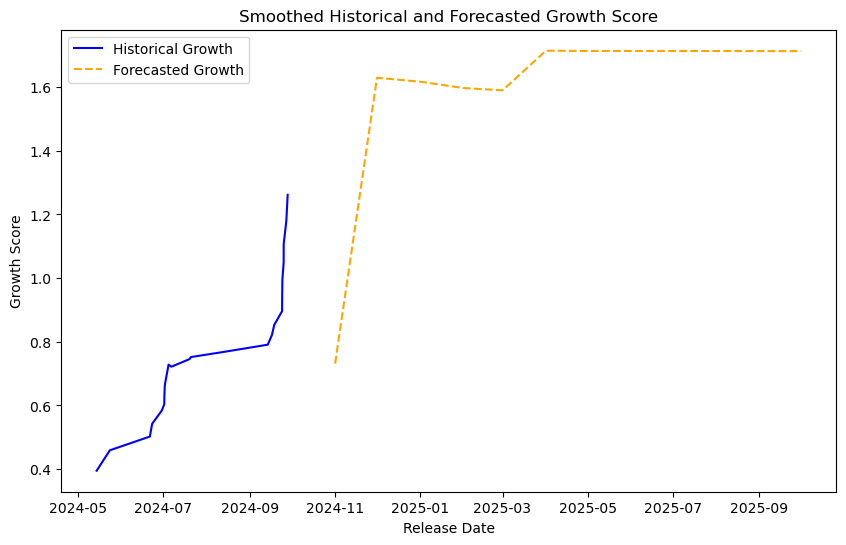

In [214]:
import pandas as pd
# Generate future dates for the forecasted values based on the release_date index by Monthly frequency
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['growth_score'], color='blue', label='Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')


plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()

In [215]:
forecasted_values

array([0.73143303, 1.6294725 , 1.6170449 , 1.597182  , 1.5898643 ,
       1.7143999 , 1.7135684 , 1.7135949 , 1.7135476 , 1.7134144 ,
       1.7132109 , 1.7132115 ], dtype=float32)